In [77]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image
import os
import argparse
import time
from tqdm import trange
from tensorboardX import SummaryWriter
from collections import OrderedDict
from torchsummary import summary

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import RetinaMNIST
from medmnist import INFO, Evaluator

In [78]:
num_samples = 8
info = INFO["retinamnist"]
DataClass = getattr(medmnist, info['python_class'])
data_transform = transforms.Compose([transforms.ToTensor()])
train_dataset = DataClass(split='train', transform=data_transform, download=True, as_rgb=True)
train_loader = data.DataLoader(train_dataset, batch_size=num_samples, shuffle=True)

Using downloaded and verified file: /home/matthijs/.medmnist/retinamnist.npz


torch.Size([3, 28, 28])


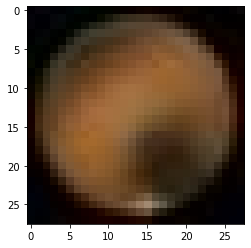

In [79]:
input, label = next(iter(train_loader))
print(input[7].shape)
plt.imshow(np.swapaxes(input[7],0,2))

In [81]:

class MyModel(nn.Module):
    def __init__(self, input_size):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 5)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = x.reshape((x.shape[0], x.shape[1]*x.shape[2]*x.shape[3]))
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x
    

def train(model, criterion, optimizer, device, writer, inputs, targets):
    total_loss = []
    global iteration

    model.train()
    # for batch_idx, (inputs, targets) in enumerate(train_loader):
    #     if batch_idx > num_batches: # for now, let's only look at two batches
    #         break
    optimizer.zero_grad()
    outputs = model(inputs.to(device))

    targets = torch.squeeze(targets, 1).long().to(device)
    loss = criterion(outputs, targets)

    total_loss.append(loss.item())
    writer.add_scalar('train_loss_logs', loss.item())
    loss.backward()
    optimizer.step()
    G_layer1 = model.fc1.weight.grad
    G_layer2 = model.fc2.weight.grad
    G_layers = [G_layer1, G_layer2]
        # print(model.fc2.weight.grad[0])
    #     if batch_idx==0:
    #         G_layer1 = model.fc1.weight.grad
    #         G_layer2 = model.fc2.weight.grad
    #     else:
    #         G_layer1 += model.fc1.weight.grad
    #         G_layer2 += model.fc2.weight.grad

    # G_layer1 /= num_batches
    # G_layer2 /= num_batches
    epoch_loss = sum(total_loss)/len(total_loss)
    return epoch_loss, G_layers


# Define model and optimizer
model = MyModel(3*28*28)
optimizer = optim.Adam(model.parameters())

# Define loss function
criterion = nn.CrossEntropyLoss()
writer = SummaryWriter()


inputs, targets = next(iter(train_loader))
epoch_loss, G_layers = train(model, criterion, optimizer, "cpu", writer, inputs, targets)




/tmp/ipykernel_6278/2726593962.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


In [82]:
######################################################################################
######################################################################################
# This Part includes Algorithm B.1 and B.2 from the paper. The assumptions made are: #
# 1. g1 is bigger than 0, for all samples 2. we need to take a threshold to compare  #
# constants in r_2.                                                                  #
######################################################################################
######################################################################################
from random import choice

TH_POW = 8

def exact_label_reconstruction(loss_vector_ratio):
    if np.sum(loss_vector_ratio<0)>0: # The bigger than sign, I am not sure about
        return np.argmin(loss_vector_ratio) # I am not sure about this either
    else:
        return 0

def find_disjoint_index_groups(arr: np.ndarray) -> dict:
    unique_vals, counts = np.unique(arr, return_counts=True)
    dup_vals = unique_vals[(counts>1)*(~np.isinf(unique_vals))*(~np.isnan(unique_vals))]
    I = {}
    for i, val in enumerate(dup_vals):
        I[f"m_{i}"] = np.argwhere(arr==val).flatten()
    return I

#take batch 0 and epoch 0 
def determine_g(GH, output_size=5):
    G1 = GH[0]
    G = np.zeros((output_size, G1.shape[0]))
    r = np.zeros((output_size, G1.shape[0]))

    for c in range(output_size):
        G[c] = GH[c]
        r[c] = np.round(G[c]/G1, TH_POW) # This threshold is to avoid numerical errors

    r_2 = r[1]
    exans = False
    disjoint_index_groups = find_disjoint_index_groups(r_2)

    if len(disjoint_index_groups)>0:
        print("disjoint index group", disjoint_index_groups)
        exans = True

    if exans:
        reconstructable_samples = len(disjoint_index_groups)
        ratio_vector = np.zeros((output_size, reconstructable_samples))
        for c in range(output_size):
            for m in range(reconstructable_samples):
                j = choice(disjoint_index_groups[f"m_{m}"])
                ratio_vector[c][m] = r[c][j]

        g1 = np.zeros((reconstructable_samples))
        g = np.zeros((reconstructable_samples, output_size))
        for m in range(reconstructable_samples):
            Ym = exact_label_reconstruction(ratio_vector[:, m])
            delta_m = 1/ratio_vector[Ym, m]
            g1[m] = 2 * delta_m/3
            g[m] = ratio_vector[:, m] * g1[m]
        return disjoint_index_groups, g, reconstructable_samples

    else:
        print("no exans")
        return None, None, None

disjoint_index_groups, g, reconstructable_samples = determine_g(G_layers[1])
print(g)


disjoint index group {'m_0': array([210, 483]), 'm_1': array([231, 255]), 'm_2': array([205, 335]), 'm_3': array([ 58, 113, 345, 396]), 'm_4': array([168, 370, 445, 465]), 'm_5': array([  0,  53, 204]), 'm_6': array([203, 364]), 'm_7': array([ 75, 457]), 'm_8': array([314, 489]), 'm_9': array([169, 197])}
[[-0.17318639  0.66666667 -0.15881026 -0.17172424 -0.16294578]
 [-0.17318639  0.66666667 -0.15881026 -0.17172423 -0.16294578]
 [-0.1731864   0.66666667 -0.15881026 -0.17172425 -0.1629458 ]
 [-2.52341946  0.66666667  0.58213265  0.66150456  0.61311554]
 [-2.52341956  0.66666667  0.58213269  0.66150453  0.61311559]
 [-2.5234195   0.66666667  0.58213269  0.66150456  0.61311559]
 [-2.52341968  0.66666667  0.58213269  0.66150456  0.61311556]
 [-2.55684977  0.63188622  0.61588661  0.66666667  0.64241058]
 [-0.17804951 -0.17337612 -0.15770155  0.66666667 -0.15753947]
 [-0.17804952 -0.17337612 -0.15770156  0.66666667 -0.15753946]]


/home/matthijs/anaconda3/lib/python3.9/site-packages/torch/_tensor.py:643: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other


In [83]:
#######################################################################################
#######################################################################################
# This Part includes Algorithm B.3 from the paper. The implementation is not complete #
# yet, because there are some gaps in the understanding of the paper.                 #
#######################################################################################
#######################################################################################

def determine_activation_pattern(G, IH, g, M):
    I_cur = IH
    D = {}
    for i in reversed(range(len(G)-1)):
        D[f"layer_{i}"] = {}
        for m in range(M):
            j = choice(I_cur[f"m_{m}"])
            D[f"layer_{i}"][f"m_{m}"] = np.diag(G[i][j][G[i][j]!=0]) # needs to be D[i][m] but for now, let's just do it for one sample
            # # also how come we select a random j, whiy dont we use all?
            # # and why only nonzero values? because this leads to inconsistent dimensions
        # I_cur = find_disjoint_index_groups(?) How do we find the d
    # there is no sensible way to solve the D from the binary equation, because here the weights would not have the same dimensions as D
    return D
D = determine_activation_pattern(G_layers, disjoint_index_groups, g, reconstructable_samples)